# My inputs

In [1]:
import os
import sys
import pandas as pd
import re
from IPython.display import clear_output

# Kernel inputs

In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Models inputs

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

# Initialisation path scripts

In [4]:
path_to_scripts = r'..\02_SCRIPTS'

In [5]:
sys.path.insert(0, path_to_scripts)

# Import functions

In [6]:
from P7_dataprep_function import main

In [7]:
from P7_other_functions import TrainTestGrid, \
    heatmap_print, \
    classify_with_proba

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 0s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 26)
Process installments payments - done in 0s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 0s
Starting LightGBM. Train shape: (10000, 768), test shape: (10000, 768)
Fold  1 AUC : 0.725420
Fold  2 AUC : 0.716144
Fold  3 AUC : 0.709659
Fold  4 AUC : 0.731546
Fold  5 AUC : 0.727236
Fold  6 AUC : 0.739950
Fold  7 AUC : 0.716610
Fold  8 AUC : 0.677266
Fold  9 AUC : 0.720636
Fold 10 AUC : 0.692298
Full AUC score 0.715643


C:\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Run LightGBM with kfold - done in 397s


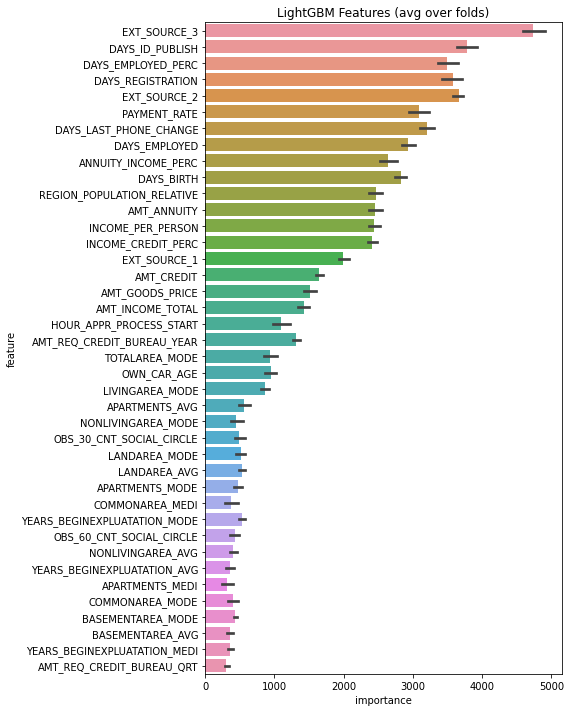

In [8]:
feat_importance, top_feat, df = main(test_importance=True)

# Univaried analysis

In [9]:
num_rows = 10000

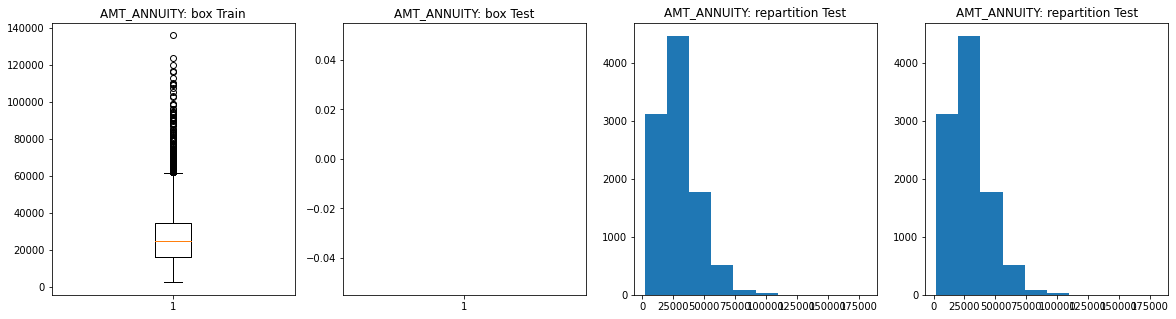

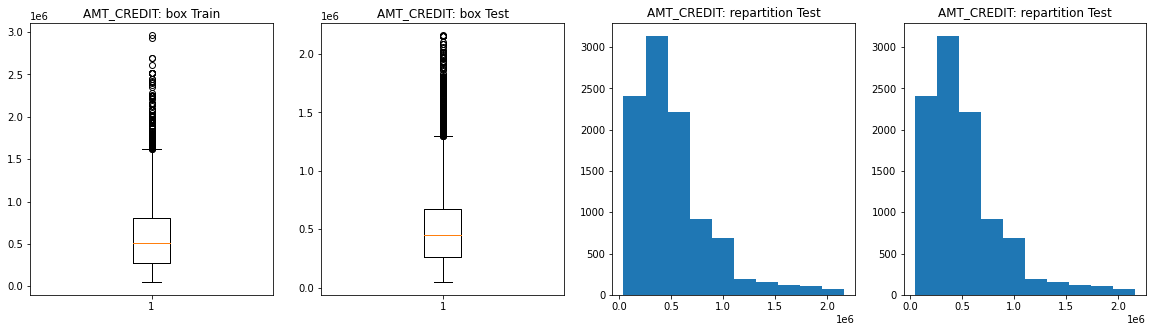

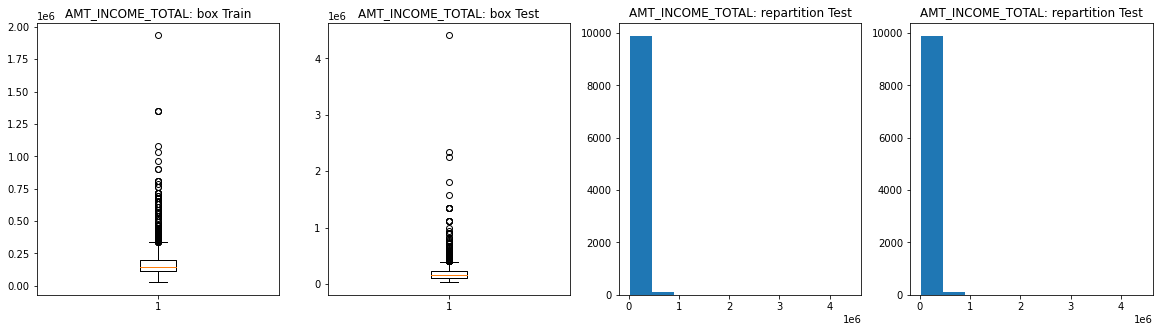

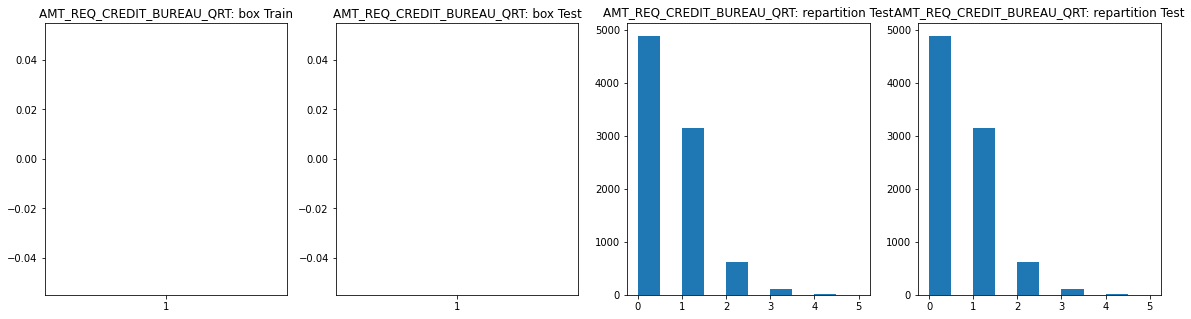

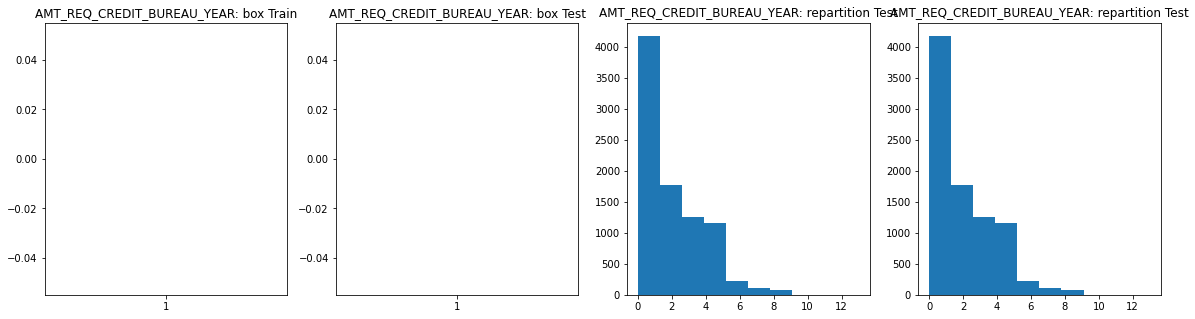

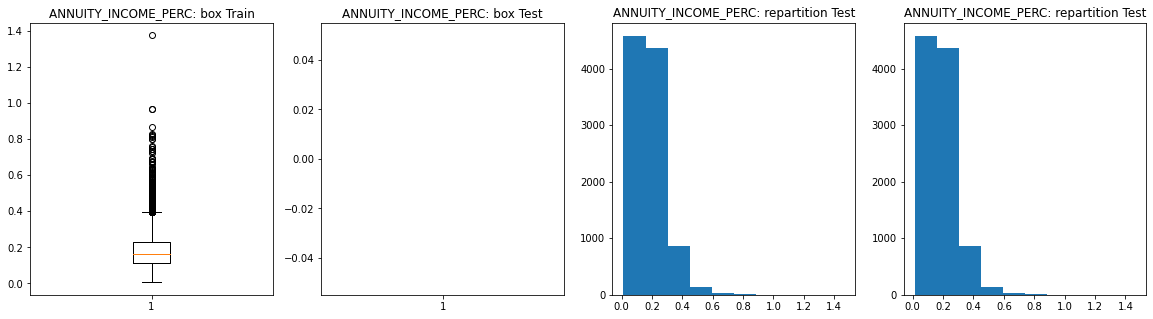

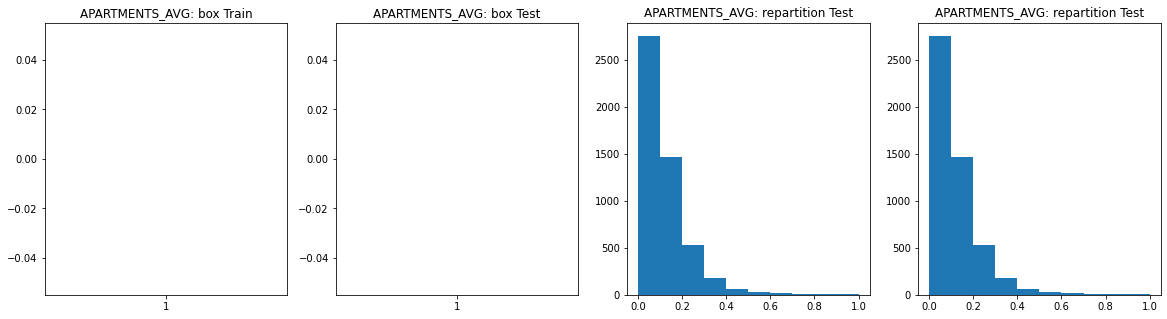

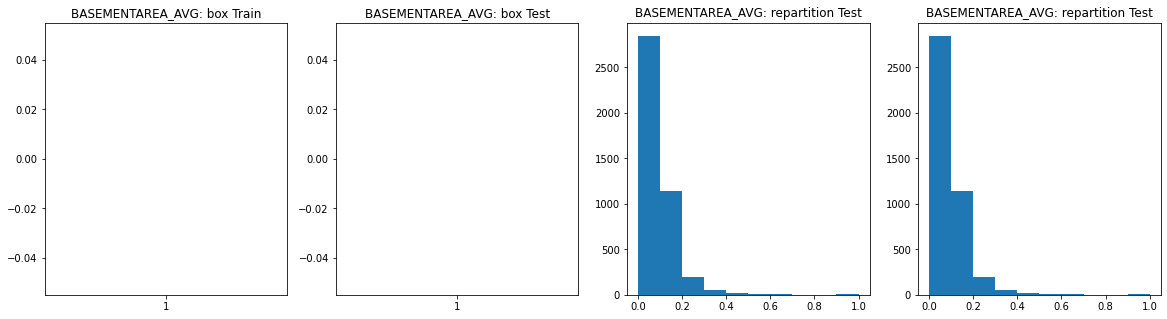

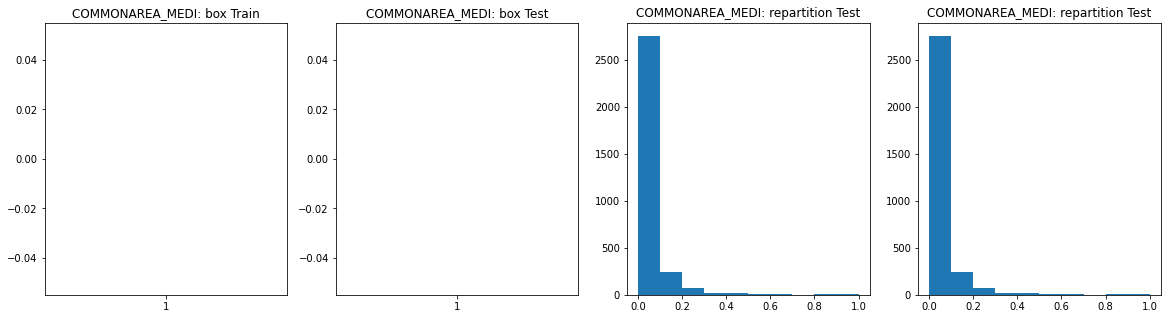

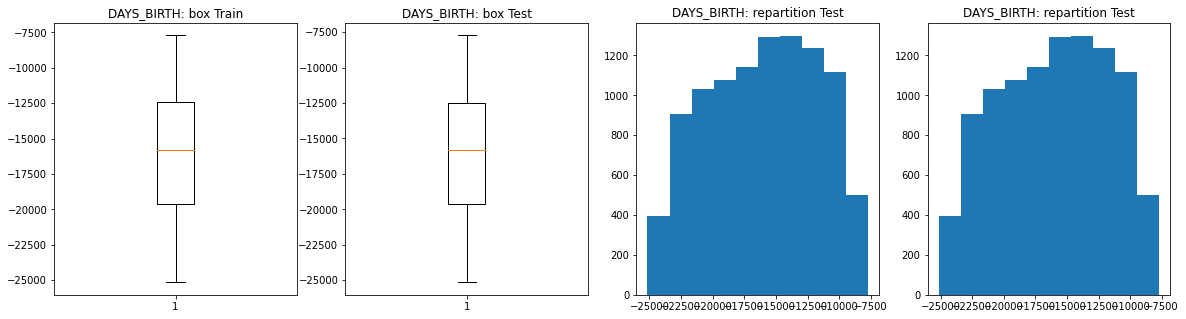

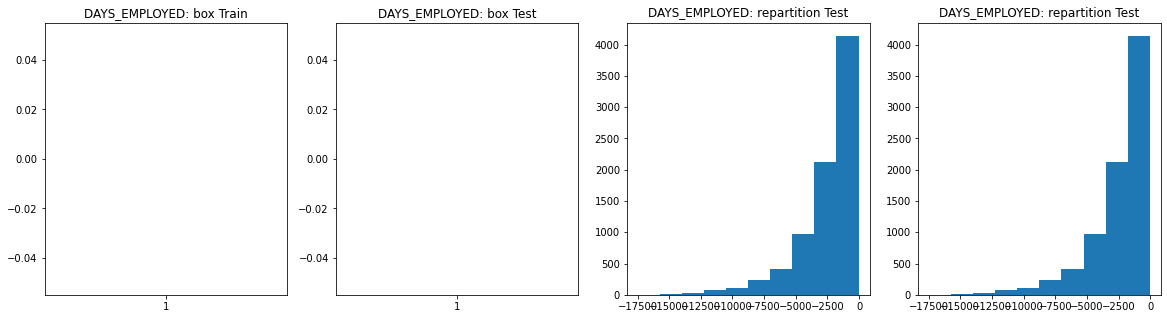

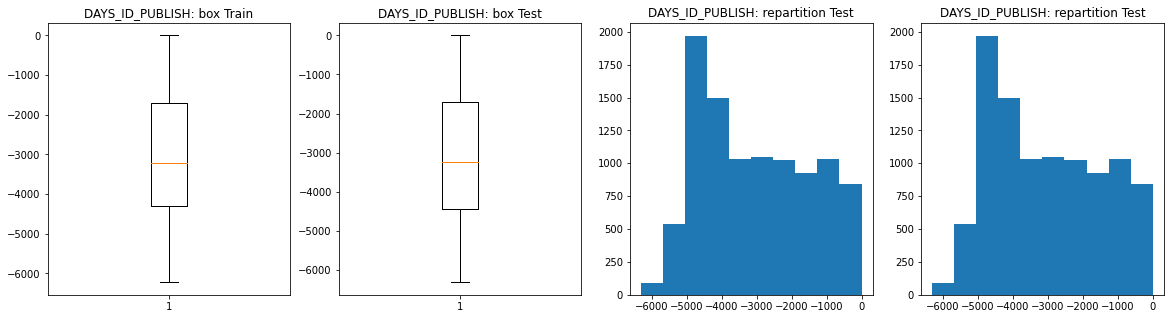

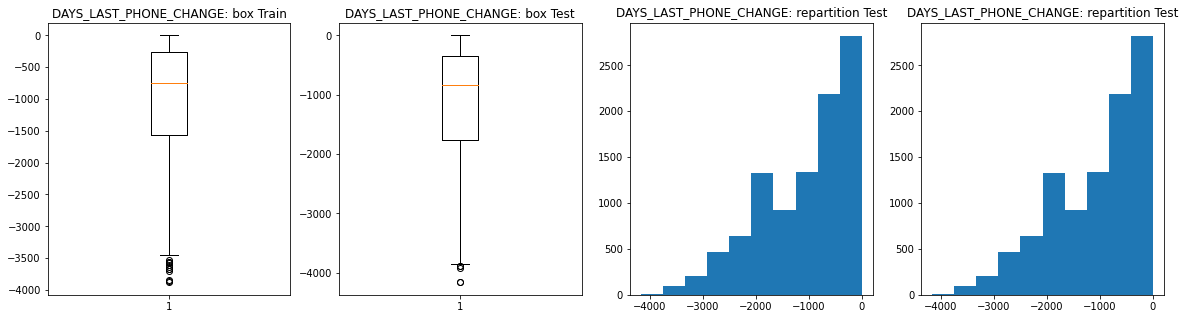

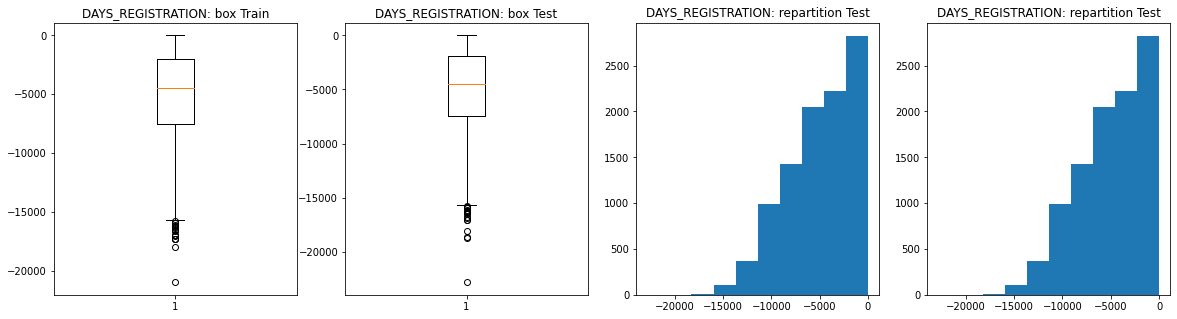

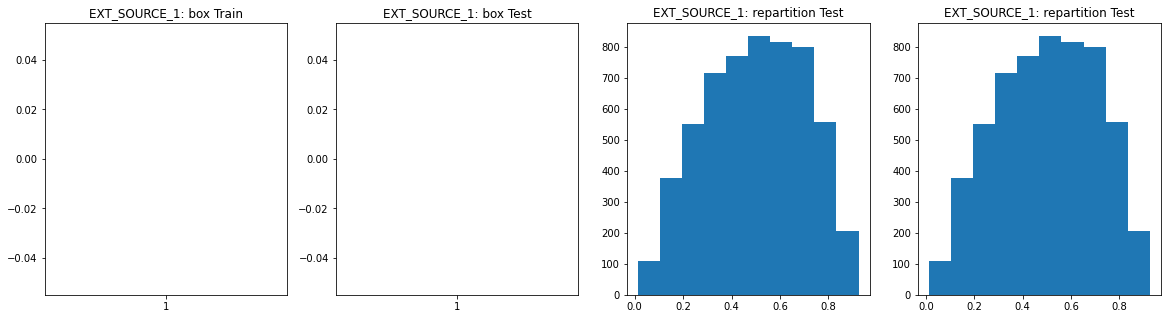

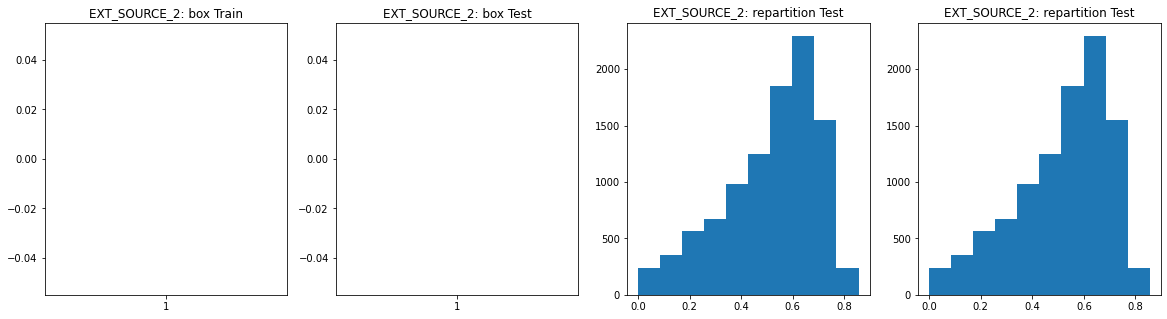

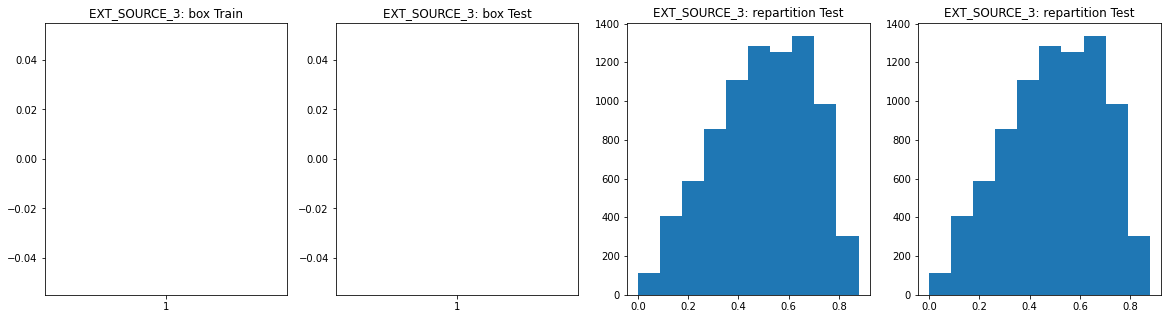

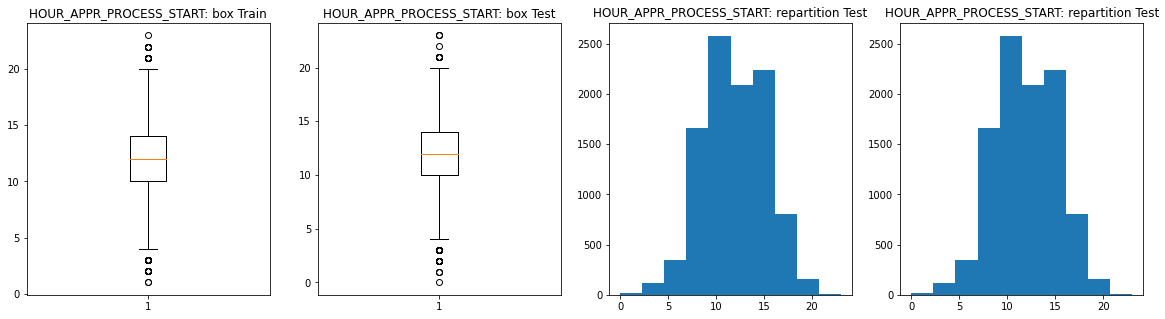

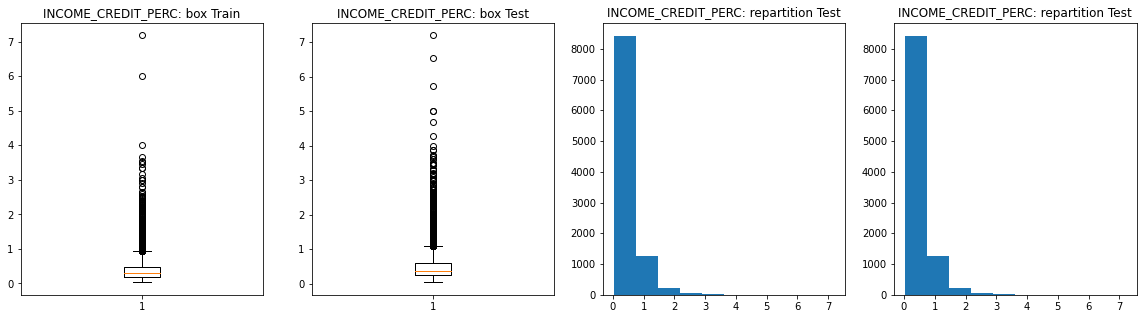

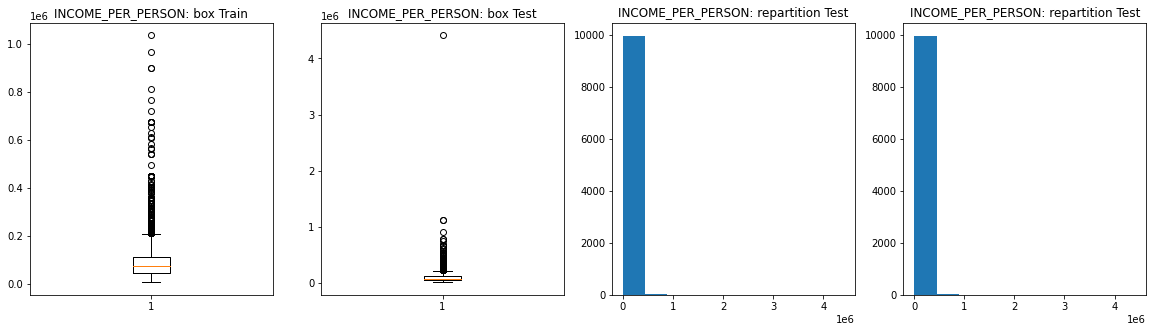

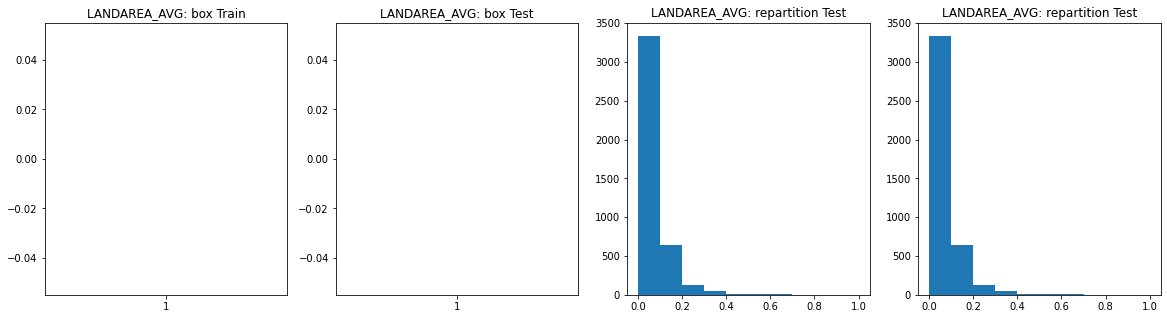

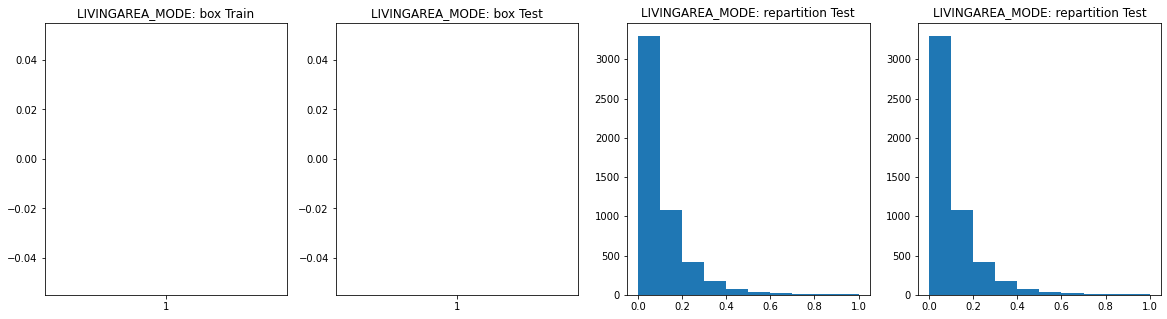

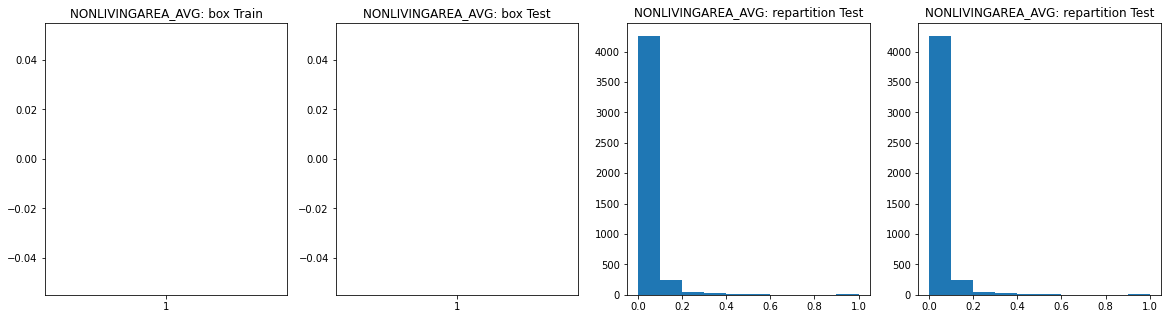

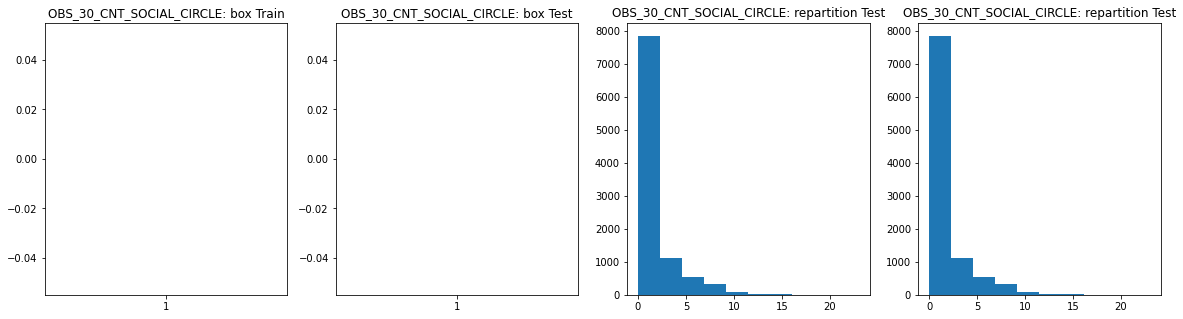

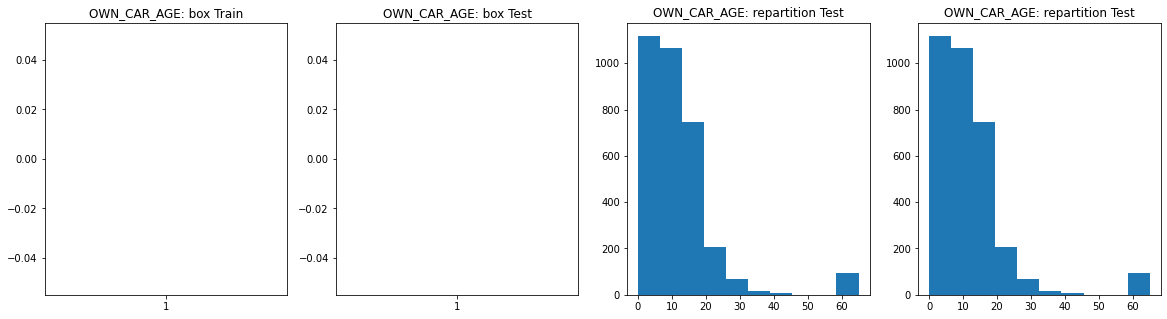

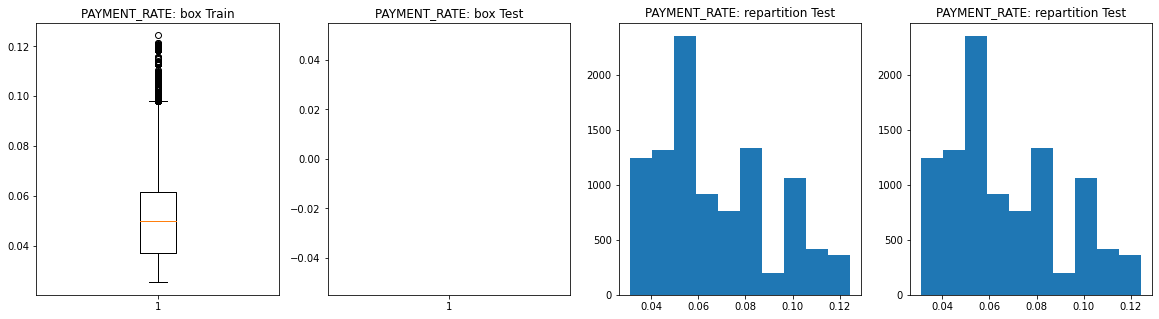

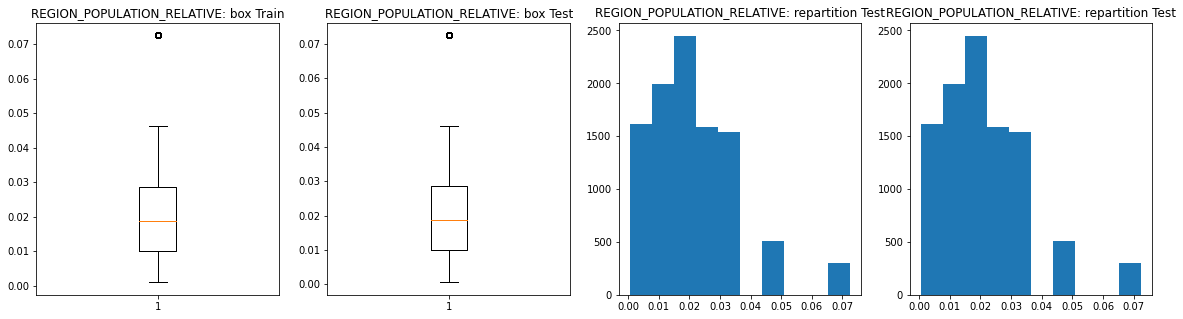

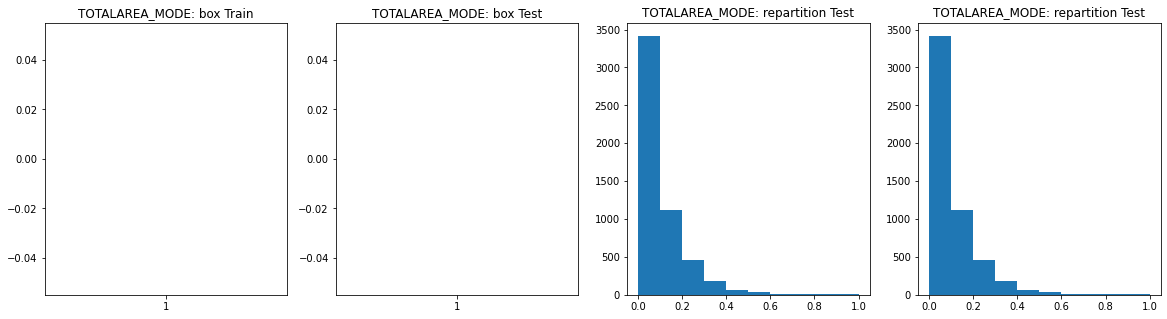

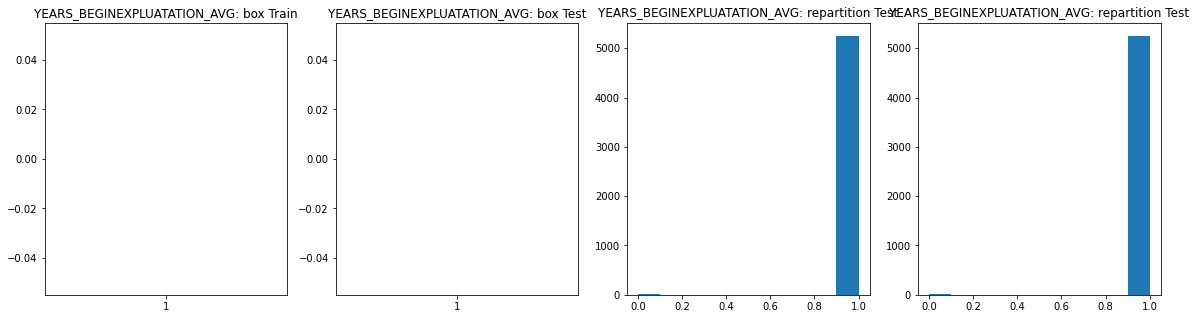

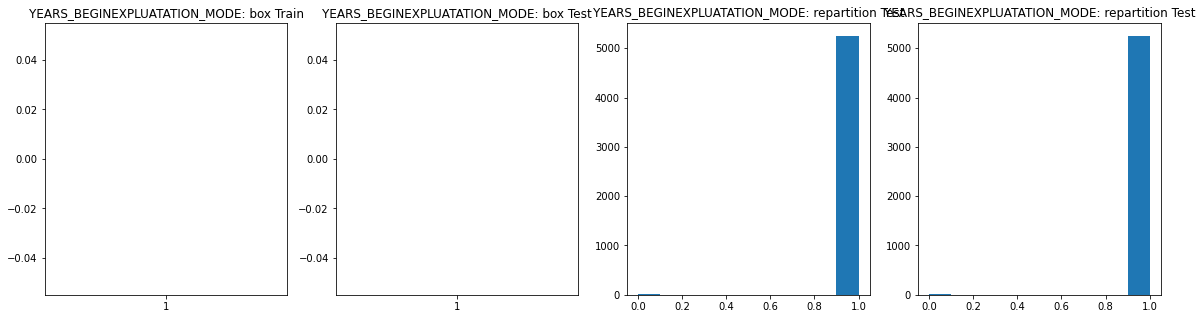

In [10]:
for feat in top_feat:
    plt.figure(figsize=(20,5))
    plt.subplot(1, 4, 1)
    plt.boxplot(df[feat][:num_rows])
    plt.title('{}: box Train'.format(feat))
    plt.subplot(1, 4, 2)
    plt.boxplot(df[feat][num_rows:])
    plt.title('{}: box Test'.format(feat))
    plt.subplot(1, 4, 3)
    plt.hist(df[feat][num_rows:])
    plt.title('{}: repartition Test'.format(feat))
    plt.subplot(1, 4, 4)
    plt.hist(df[feat][num_rows:])
    plt.title('{}: repartition Test'.format(feat))
    plt.show()

In [11]:
top_feat

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'ANNUITY_INCOME_PERC',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'COMMONAREA_MEDI',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'HOUR_APPR_PROCESS_START',
 'INCOME_CREDIT_PERC',
 'INCOME_PER_PERSON',
 'LANDAREA_AVG',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OWN_CAR_AGE',
 'PAYMENT_RATE',
 'REGION_POPULATION_RELATIVE',
 'TOTALAREA_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MODE']

In [12]:
df_modele = df[top_feat + ['TARGET']]
df_modele

,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,APARTMENTS_AVG,BASEMENTAREA_AVG,COMMONAREA_MEDI,DAYS_BIRTH,...,LIVINGAREA_MODE,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,PAYMENT_RATE,REGION_POPULATION_RELATIVE,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MODE,TARGET
0,24700.5,406597.5,202500.0,0.0,1.0,0.121978,0.0247,0.0369,0.0144,-9461,...,0.0198,0.0000,2.0,NaN,0.060749,0.018801,0.0149,0.9722,0.9722,1.0
1,35698.5,1293502.5,270000.0,0.0,0.0,0.132217,0.0959,0.0529,0.0608,-16765,...,0.0554,0.0098,1.0,NaN,0.027598,0.003541,0.0714,0.9851,0.9851,0.0
2,6750.0,135000.0,67500.0,0.0,0.0,0.100000,NaN,NaN,NaN,-19046,...,NaN,NaN,0.0,26.0,0.050000,0.010032,NaN,NaN,NaN,0.0
3,29686.5,312682.5,135000.0,NaN,NaN,0.219900,NaN,NaN,NaN,-19005,...,NaN,NaN,2.0,NaN,0.094941,0.008019,NaN,NaN,NaN,0.0
4,21865.5,513000.0,121500.0,0.0,0.0,0.179963,NaN,NaN,NaN,-19932,...,NaN,NaN,0.0,NaN,0.042623,0.028663,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,29173.5,454500.0,135000.0,0.0,0.0,0.216100,0.0979,0.0552,NaN,-18338,...,0.1028,0.1145,0.0,NaN,0.064188,0.028663,0.0721,0.9717,0.9717,NaN
19996,52555.5,500490.0,180000.0,0.0,1.0,0.291975,0.0577,NaN,NaN,-15040,...,0.0318,0.0104,2.0,18.0,0.105008,0.046220,0.0020,0.9752,0.9752,NaN
19997,37336.5,523152.0,202500.0,NaN,NaN,0.184378,0.1381,0.1397,NaN,-17225,...,0.1256,0.0039,0.0,NaN,0.071368,0.032561,0.0956,0.9752,0.9752,NaN
19998,31338.0,967500.0,382500.0,0.0,3.0,0.081929,0.2603,0.1686,0.0385,-14852,...,0.1473,0.0064,1.0,NaN,0.032391,0.072508,0.2784,0.9791,0.9791,NaN


In [13]:
df_modele_train = df_modele[:num_rows].fillna(0)
df_modele_test = df_modele[num_rows:].fillna(0)

# Target observations

In [14]:
df_modele_train.TARGET.value_counts()

0.0    9225
1.0     775
Name: TARGET, dtype: int64

In [15]:
val0 = (df_modele_train.TARGET == 0).sum()
val1 = (df_modele_train.TARGET == 1).sum()

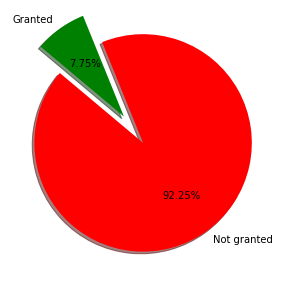

In [16]:
labels = ['Not granted', 'Granted']
values = [val0, val1]
colors = ['red', 'green']
explode = (0, 0.3)
plt.figure(figsize=(10, 5))
plt.pie(values,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct='%.2f%%',
        shadow=True,
        startangle=140)
plt.show()

# Classification
#### KNN, SVC

### Undersampling

In [17]:
class_count_0, class_count_1 = df_modele_train['TARGET'].value_counts()

In [18]:
class_0 = df_modele_train[df_modele_train['TARGET'] == 0]
class_1 = df_modele_train[df_modele_train['TARGET'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (9225, 31)
class 1: (775, 31)


total class:
 0.0    775
1.0    775
Name: TARGET, dtype: int64


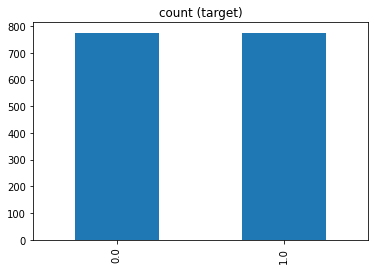

In [19]:
# get random sample of class 1
class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total class:\n",test_under['TARGET'].value_counts())
test_under['TARGET'].value_counts().plot(kind='bar', title='count (target)')
plt.show()

DUMMY train time : 0.0


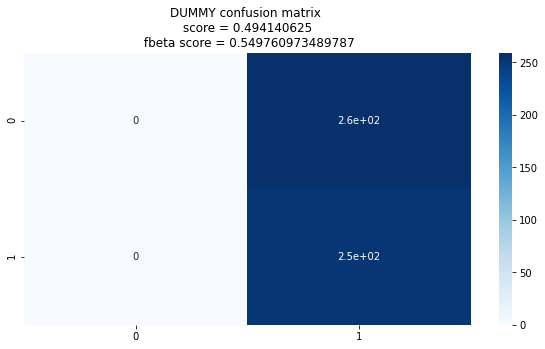

In [20]:
TrainTestGrid(test_under[top_feat], test_under.TARGET, method='dummy')

In [21]:
#TrainTestGrid(test_under[top_feat], test_under.TARGET, method='sgd', n_esti=50)

In [22]:
#TrainTestGrid(test_under[top_feat], test_under.TARGET, method='svc')

Grid best score : 0.552734375
Grid best params : {'algorithm': 'auto', 'n_neighbors': 29}
Bagging with 50 estimators
Bagged KNN train time : 0.04687356948852539
KNN train time : 0.0


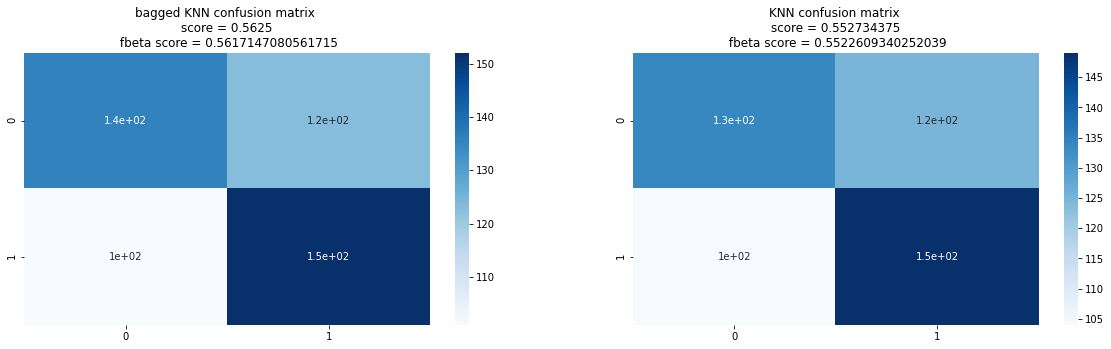

In [23]:
under_knn_results = TrainTestGrid(test_under[top_feat], test_under.TARGET, method='knn', n_esti=50)

Grid best score : 0.64453125
Grid best params : {'criterion': 'gini'}
Bagging with 50 estimators
Bagged RFC train time : 8.927027225494385
RFC train time : 0.24477291107177734


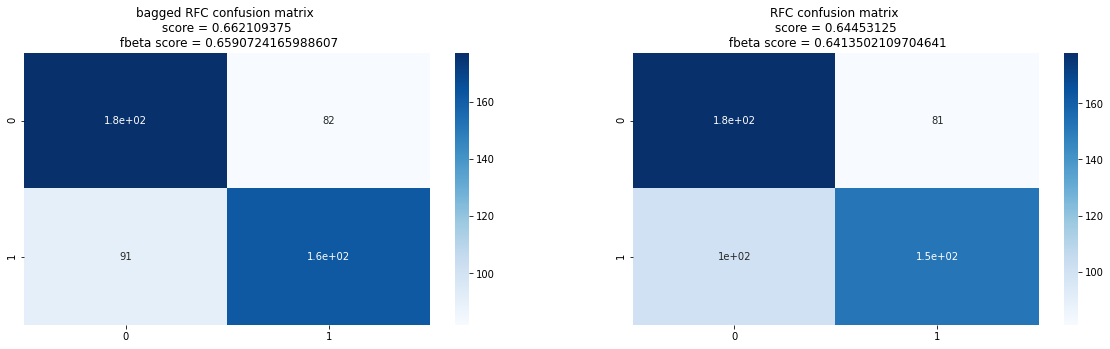

In [24]:
under_rfc_results = TrainTestGrid(test_under[top_feat], test_under.TARGET, method='rfc', n_esti=50)

### Oversampling

total class of 1 and 0: 0.0    9225
1.0    9225
Name: TARGET, dtype: int64


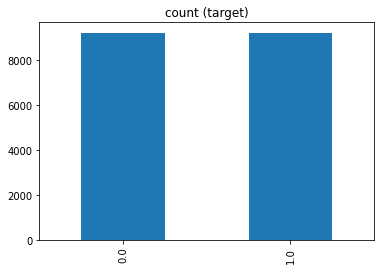

In [25]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:",test_over['TARGET'].value_counts())
test_over['TARGET'].value_counts().plot(kind='bar', title='count (target)')
plt.show()

DUMMY train time : 0.00099945068359375


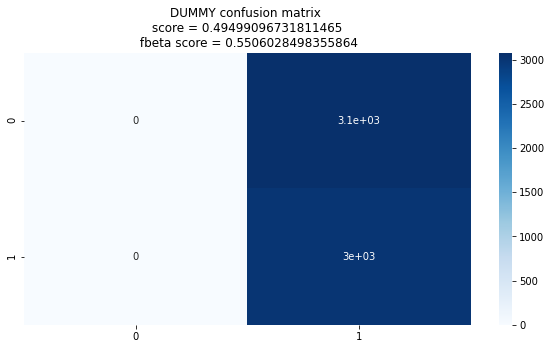

In [26]:
TrainTestGrid(test_over[top_feat], test_over.TARGET, method='dummy')

Grid best score : 0.6771226802430612
Grid best params : {'algorithm': 'auto', 'n_neighbors': 16}
Bagging with 50 estimators
Bagged KNN train time : 0.2820131778717041
KNN train time : 0.0


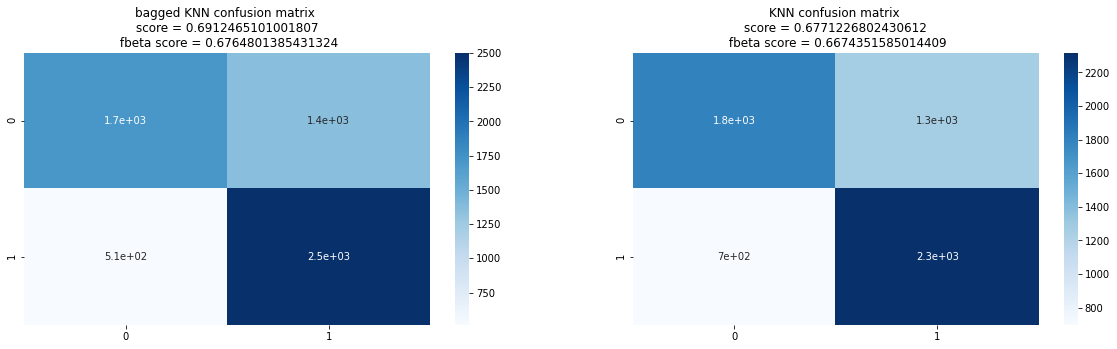

In [27]:
over_knn_results = TrainTestGrid(test_over[top_feat], test_over.TARGET, method='knn', n_esti=50)

Grid best score : 0.9949088520282476
Grid best params : {'criterion': 'gini'}
Bagging with 50 estimators
Bagged RFC train time : 71.8119101524353
RFC train time : 2.1462628841400146


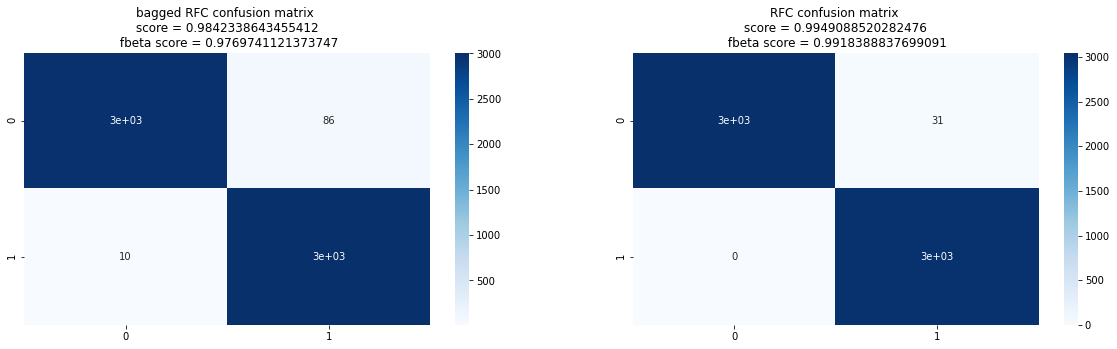

In [28]:
over_rfc_results = TrainTestGrid(test_over[top_feat], test_over.TARGET, method='rfc', n_esti=50)

In [29]:
#train_test_grid(test_over[top_feat], test_over.TARGET, method='sgd', n_esti=50)

In [30]:
#train_test_grid(test_over[top_feat], test_over.TARGET, method='svc')

### SMOTE

In [31]:
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(df_modele_train[top_feat], df_modele_train.TARGET)

print('Original dataset shape', df_modele_train[top_feat].shape)
print('Resample dataset shape', x_smote.shape)

Original dataset shape (10000, 30)
Resample dataset shape (18450, 30)


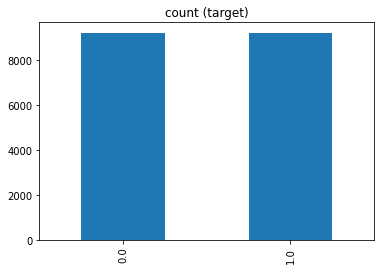

In [32]:
y_smote.value_counts().plot(kind='bar', title='count (target)')
plt.show()

DUMMY train time : 0.0


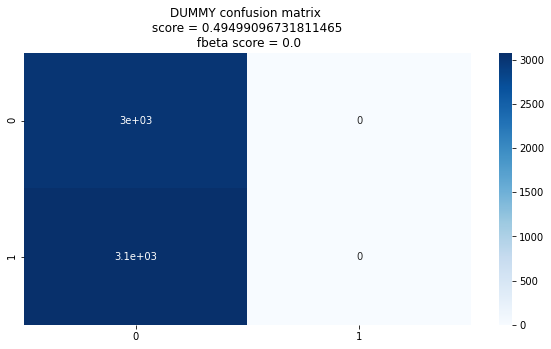

In [33]:
TrainTestGrid(x_smote, y_smote, method='dummy')

Grid best score : 0.7459352931515848
Grid best params : {'algorithm': 'auto', 'n_neighbors': 16}
Bagging with 50 estimators
Bagged KNN train time : 0.2350482940673828
KNN train time : 0.0


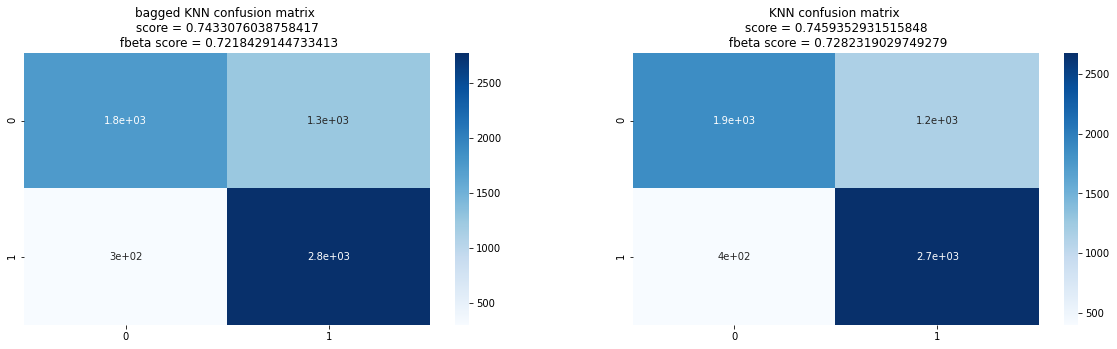

In [34]:
smote_knn_results = TrainTestGrid(x_smote, y_smote, method='knn', n_esti=50)

Grid best score : 0.9543438988339629
Grid best params : {'criterion': 'gini'}
Bagging with 50 estimators
Bagged RFC train time : 90.37826991081238
RFC train time : 2.901215076446533


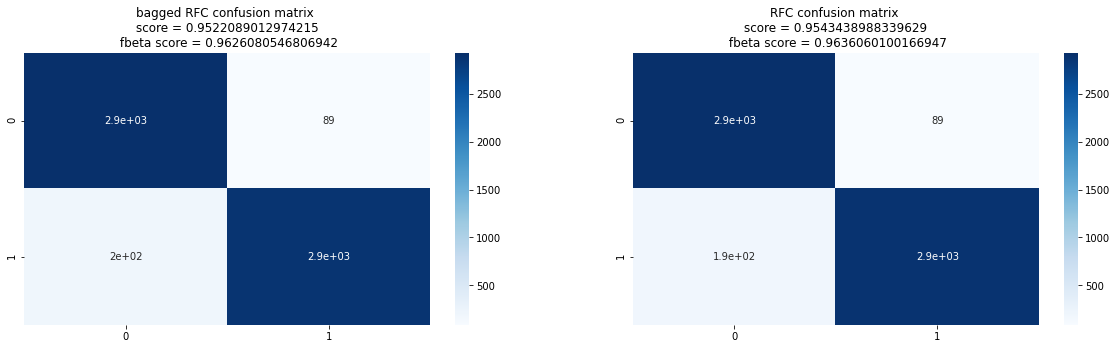

In [35]:
smote_rfc_results = TrainTestGrid(x_smote, y_smote, method='rfc', n_esti=50)

In [36]:
#train_test_grid(x_smote, y_smote, method='sgd', n_esti=50)

##### On peut donc retenir comme méthode :
##### préprocessing/balancing = over_sampling
##### classifier = Random Forest Classifier
##### bagged = Non

## Prediction score and prediction using score

### Train test split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    test_over[top_feat],
    test_over.TARGET,
    test_size=0.33,
    random_state=0)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    x_smote,
    y_smote,
    test_size=0.33,
    random_state=0)

### RFC best params

In [52]:
params = {
    'n_estimators': [200, 250, 300, 350, 400],
    'criterion': ['gini', 'entropy']
}

In [53]:
grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=params)
grid.fit(X_train, y_train)
print('Grid best score :', grid.score(X_test, y_test))
print('Grid best params :', grid.best_params_)

Grid best score : 0.9573000492691739
Grid best params : {'criterion': 'gini', 'n_estimators': 400}


In [54]:
cls = RandomForestClassifier(**grid.best_params_)

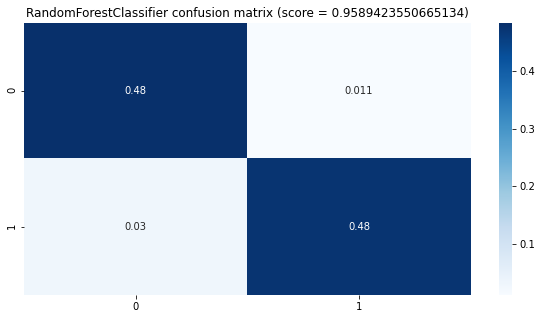

In [55]:
cls.fit(X_train, y_train)
pred = cls.predict(X_test)
true = y_test.values
title_hm = 'RandomForestClassifier confusion matrix (score = {})'.format(
    cls.score(X_test, y_test))
heatmap_print(true, pred, title_hm)

In [56]:
real_x = df_modele_train[top_feat]
real_y = df_modele_train.TARGET

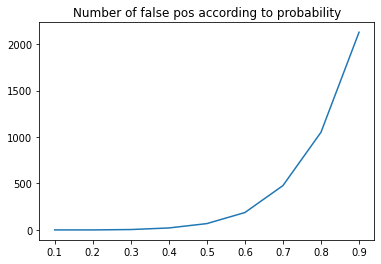

In [57]:
scores = []
false_pos_values = []
range_values = list(range(1, 10))
for proba_range in range_values:
    proba = proba_range / 10
    proba_pred = cls.predict_proba(X_test)
    pred_with_proba = np.apply_along_axis(classify_with_proba, 1, proba_pred, proba_0=proba)
    cm = confusion_matrix(y_test, pred_with_proba)
    false_pos_values += [cm[0, 1]]
plt.plot(np.divide(range_values ,10), false_pos_values)
plt.title('Number of false pos according to probability')
plt.show()

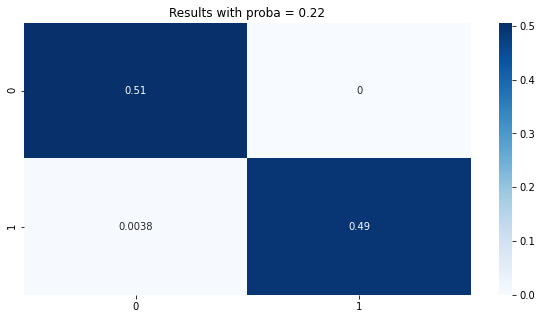

In [44]:
proba = 0.22
proba_pred = cls.predict_proba(X_test)
pred_with_proba = np.apply_along_axis(classify_with_proba, 1, proba_pred, proba_0=proba)
title_hm = 'Results with proba = {}'.format(proba)
heatmap_print(true, pred_with_proba, title_hm)

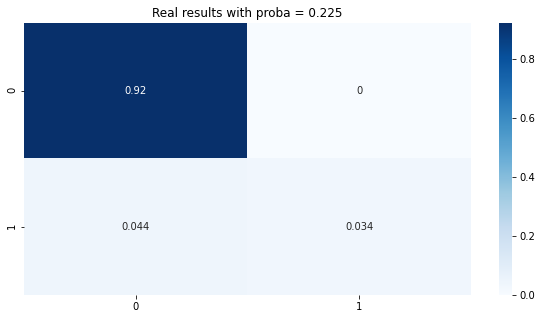

In [58]:
proba = 0.225
proba_pred = cls.predict_proba(real_x)
pred_with_proba = np.apply_along_axis(classify_with_proba, 1, proba_pred, proba_0=proba)
title_hm = 'Real results with proba = {}'.format(proba)
heatmap_print(real_y, pred_with_proba, title_hm)

# RFC validation

In [59]:
df_glo = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 23s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 26s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 14s
Installments payments df shape: (339587, 26)
Process installments payments - done in 33s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 18s


In [60]:
df_glo_train = df_glo[:307511].fillna(0)
df_glo_test = df_glo[-48744:].fillna(0)

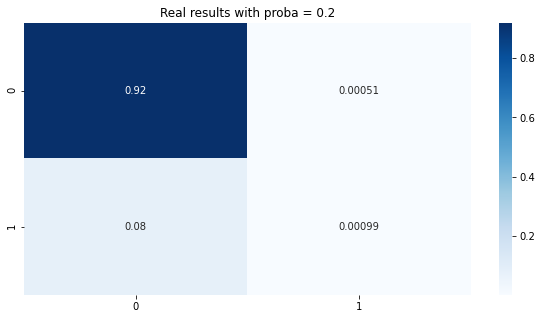

In [62]:
proba = 0.2
proba_pred = cls.predict_proba(df_glo_train[top_feat])
pred_with_proba = np.apply_along_axis(classify_with_proba, 1, proba_pred, proba_0=proba)
title_hm = 'Real results with proba = {}'.format(proba)
heatmap_print(df_glo_train.TARGET, pred_with_proba, title_hm)

##### unsatisfying results

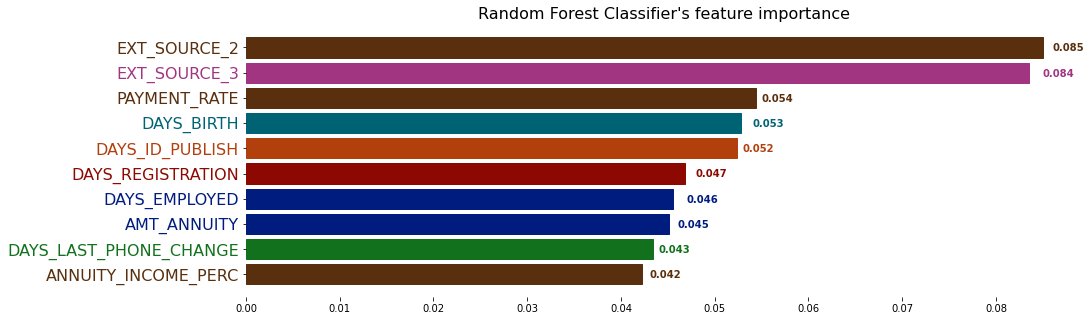

In [49]:
top_x = 10 # Top X importance (top 10 for example)
color_list =  sns.color_palette("dark", len(top_feat)) 
feat_imp = cls.feature_importances_
ind = np.argsort(feat_imp)
ind = ind[-top_x:]
fig, axs = plt.subplots(1,1, figsize=(15, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.8)
bars = axs.barh(range(len(ind)), feat_imp[ind], color='b', align='center') 
axs.set_title("Random Forest Classifier's feature importance", fontweight="normal", fontsize=16)
plt.sca(axs)
plt.yticks(range(len(ind)), [top_feat[j] for j in ind], fontweight="normal", fontsize=16)

for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[ind[i]])

for i,bar in enumerate(bars):
    bar.set_color(color_list[ind[i]])

sorted_val_imp = np.around(sorted(cls.feature_importances_), 3)[-top_x:]
for i, v in enumerate(sorted_val_imp):
    axs.text(v+0.001 , i - 0.15, str(v), color=color_list[ind[i]], fontweight='bold')

plt.box(False)